# Mountain Car

In [1]:
import pickle,random
import numpy as np
import gym
from scipy.optimize import linprog
from math import exp,pi,sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm
import mountain_car_functions as mc_funcs

## Environment

Environment: MountainCar-v0

Observation Space:  Box(2,)

Action Space:  Discrete(3)
{0: Accelerate to left
 1: Don’t accelerate
 2: Accelerate to right}

Maximum Episode Steps: 200

Bins:  120

Discretization Details:
Position: -1.2 to 0.6 	 Bin Size: 0.014999999999999998
Velocity: -0.07 to 0.07	 Bin Size: 0.0011666666666666668


A step in the environment:  (array([-0.52415953,  0.00101179]), -1.0, False, {})


Rendered Environment: 


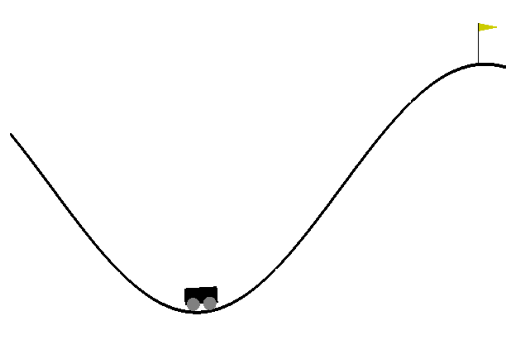

In [2]:
# Mountain Car environment
env = gym.make('MountainCar-v0')
env.seed(42)
print('Environment: MountainCar-v0')
print('\nObservation Space: ', env.observation_space)
print('\nAction Space: ', env.action_space)
print('{0: Accelerate to left\n 1: Don’t accelerate\n 2: Accelerate to right}')

# environment information
e = env.env
discretization = 120    # number of bins

# discretize state space
xmin = e.min_position                         # min value for position
xmax = e.max_position                         # max value for position
x_binsize = (xmax - xmin) / discretization    # size of each bin in the discretized space

vmin = -1 * e.max_speed                       # min value for velocity
vmax = e.max_speed                            # max value for velocity
v_binsize = (vmax - vmin) / discretization

print("\nMaximum Episode Steps:", env._max_episode_steps)
print("\nBins: ", discretization)
print("\nDiscretization Details:")
print(f"Position: {xmin} to {xmax} \t Bin Size: {x_binsize}")
print(f"Velocity: {vmin} to {vmax}\t Bin Size: {v_binsize}")
env.reset()
print('\n\nA step in the environment: ', env.step(2))
print('\n\nRendered Environment: ')
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.show()

## Training Expert (Q Learning)

In [3]:
alpha = 0.1     # learning rate
gamma = 0.99    # discount rate
epsilon = 0.1   # exploration rate

Q = mc_funcs.Q_learning_train(env, discretization, epsilon, alpha, gamma, max_episodes=20000, 
                     save=True, video_path='../Results/Mountain Car/mountain_car_training')

Training agent..:   0%|                      | 44/20000 [00:03<16:32, 20.11it/s]

Episode: 0 	 Steps: 200 	 Score: -200.0


Training agent..:  10%|██                  | 2036/20000 [00:15<09:23, 31.91it/s]

Episode: 2000 	 Steps: 200 	 Score: -200.0


Training agent..:  20%|████                | 4027/20000 [00:26<10:39, 25.00it/s]

Episode: 4000 	 Steps: 200 	 Score: -200.0


Training agent..:  30%|██████              | 6048/20000 [00:37<05:48, 39.98it/s]

Episode: 6000 	 Steps: 200 	 Score: -200.0


Training agent..:  40%|████████            | 8033/20000 [00:48<05:47, 34.45it/s]

Episode: 8000 	 Steps: 200 	 Score: -200.0


Training agent..:  50%|█████████▌         | 10025/20000 [00:59<06:07, 27.14it/s]

Episode: 10000 	 Steps: 200 	 Score: -200.0


Training agent..:  60%|███████████▍       | 12033/20000 [01:10<04:12, 31.59it/s]

Episode: 12000 	 Steps: 200 	 Score: -200.0


Training agent..:  70%|█████████████▎     | 14035/20000 [01:21<02:56, 33.85it/s]

Episode: 14000 	 Steps: 200 	 Score: -200.0


Training agent..:  80%|███████████████▏   | 16046/20000 [01:32<02:01, 32.45it/s]

Episode: 16000 	 Steps: 200 	 Score: -200.0


Training agent..:  90%|█████████████████▏ | 18068/20000 [01:42<00:42, 45.37it/s]

Episode: 18000 	 Steps: 200 	 Score: -200.0


Training agent..: 100%|██████████████████| 20000/20000 [01:50<00:00, 181.47it/s]


In [4]:
# Saving Q_optim
file_path = './data/Q_opt.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(Q, file)
    print('Saved Q Table')

Saved Q Table


In [3]:
file_path = './data/Q_opt.pkl'
with open(file_path, 'rb') as file:
    Q = pickle.load(file)
    print('Loaded Q Table')

Loaded Q Table


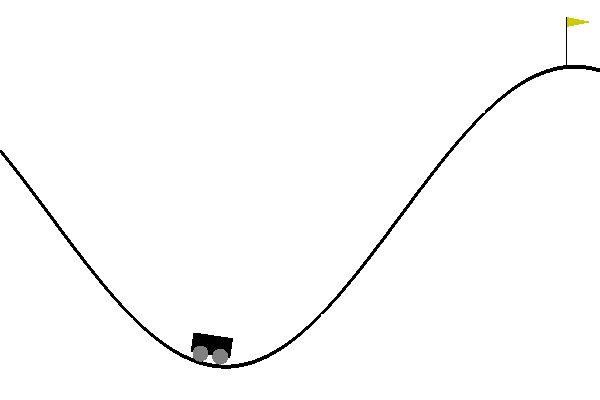

In [6]:
# Rendering trained Q-learning agent's performance in the environment

mc_funcs.render_agent(env, Q, render_filename='../Results/Mountain Car/Render')

# Inverse Reinforcement Learning

## Basis Functions

In [4]:
# function to generate set of evenly spaced basis functions

def generate_basis_functions(num_of_basis, min_value, max_value):
    basis_bin = (max_value - min_value) / (num_of_basis - 1)
    basis = [min_value + basis_bin * i for i in range(num_of_basis - 1)] + [max_value]
    return basis

In [5]:
num_of_basis = 26
basis = generate_basis_functions(num_of_basis, min_value=xmin, max_value=0.6)

# each value in the list corresponds to the starting point of a basis function
print('\nGenerated basis functions for linear approximation:\n\n', basis)


Generated basis functions for linear approximation:

 [-1.2, -1.128, -1.056, -0.984, -0.9119999999999999, -0.84, -0.768, -0.696, -0.624, -0.552, -0.48, -0.40800000000000003, -0.3360000000000001, -0.264, -0.19199999999999995, -0.1200000000000001, -0.04800000000000004, 0.02400000000000002, 0.09599999999999986, 0.16799999999999993, 0.24, 0.31199999999999983, 0.3839999999999999, 0.45599999999999996, 0.5279999999999998, 0.6]


## Value Functions

In [6]:
# function for calculating the probability density function (PDF) of a normal distribution

def get_pdf(x, mean, std_dev):
    z = (x - mean) / std_dev
    pdf = (exp(-(z**2) / 2) / (sqrt(2 * pi) * std_dev))
    return pdf

In [7]:
# calculate the value function through Q Learning

def get_value_function(Q, mean, scale, num, alpha=0.1, gamma=0.99, epsilon=0.05, 
                       max_episodes=10000, save_path='./data/V'):

    V = [[0 for _ in range(120)] for _ in range(120)]

    for episode in tqdm(range(max_episodes), desc=f'Calculating Value Function {i}..'):
        obs = env.reset()

        while True:
            x, v = mc_funcs.get_state(obs)
            a = np.argmax(np.array(Q[x][v]))

            obs, R, done, info = env.step(a)
            R = get_pdf(x, mean, scale)

            x1, v1 = mc_funcs.get_state(obs)  # get next state (x1, v1)

            V[x][v] += alpha * (R + gamma * V[x1][v1] - V[x][v])  # V(x, v) ← V(x, v) + α * (R + γ * V(x', v') - V(x, v))

            if done:
                break

    # Save the value function
    if save_path:
        index_str = str(num).zfill(2)
        with open(f'{save_path}{index_str}.pkl', 'wb') as file:
            pickle.dump(V, file)
            print(f'Saved V{index_str}.pkl')

    return V

In [8]:
# calculate the value function for each basis function using Q-learning

for i in range(0, num_of_basis):
    get_value_function(Q, mean=basis[i], scale=0.5, num=i)

Calculating Value Function 0..: 100%|████| 10000/10000 [00:38<00:00, 261.39it/s]


Saved ./data/V00.pkl


Calculating Value Function 1..: 100%|████| 10000/10000 [00:38<00:00, 259.30it/s]


Saved ./data/V01.pkl


Calculating Value Function 2..: 100%|████| 10000/10000 [00:38<00:00, 258.26it/s]


Saved ./data/V02.pkl


Calculating Value Function 3..: 100%|████| 10000/10000 [00:39<00:00, 252.06it/s]


Saved ./data/V03.pkl


Calculating Value Function 4..: 100%|████| 10000/10000 [00:39<00:00, 250.95it/s]


Saved ./data/V04.pkl


Calculating Value Function 5..: 100%|████| 10000/10000 [00:42<00:00, 233.50it/s]


Saved ./data/V05.pkl


Calculating Value Function 6..: 100%|████| 10000/10000 [00:49<00:00, 203.59it/s]


Saved ./data/V06.pkl


Calculating Value Function 7..: 100%|████| 10000/10000 [00:49<00:00, 201.42it/s]


Saved ./data/V07.pkl


Calculating Value Function 8..: 100%|████| 10000/10000 [00:46<00:00, 213.17it/s]


Saved ./data/V08.pkl


Calculating Value Function 9..: 100%|████| 10000/10000 [00:38<00:00, 261.40it/s]


Saved ./data/V09.pkl


Calculating Value Function 10..: 100%|███| 10000/10000 [00:36<00:00, 271.79it/s]


Saved ./data/V10.pkl


Calculating Value Function 11..: 100%|███| 10000/10000 [00:37<00:00, 265.66it/s]


Saved ./data/V11.pkl


Calculating Value Function 12..: 100%|███| 10000/10000 [00:36<00:00, 275.54it/s]


Saved ./data/V12.pkl


Calculating Value Function 13..: 100%|███| 10000/10000 [00:36<00:00, 272.14it/s]


Saved ./data/V13.pkl


Calculating Value Function 14..: 100%|███| 10000/10000 [00:36<00:00, 271.08it/s]


Saved ./data/V14.pkl


Calculating Value Function 15..: 100%|███| 10000/10000 [00:35<00:00, 281.30it/s]


Saved ./data/V15.pkl


Calculating Value Function 16..: 100%|███| 10000/10000 [00:35<00:00, 284.00it/s]


Saved ./data/V16.pkl


Calculating Value Function 17..: 100%|███| 10000/10000 [00:35<00:00, 285.08it/s]


Saved ./data/V17.pkl


Calculating Value Function 18..: 100%|███| 10000/10000 [00:36<00:00, 272.62it/s]


Saved ./data/V18.pkl


Calculating Value Function 19..: 100%|███| 10000/10000 [00:37<00:00, 265.99it/s]


Saved ./data/V19.pkl


Calculating Value Function 20..: 100%|███| 10000/10000 [00:43<00:00, 228.45it/s]


Saved ./data/V20.pkl


Calculating Value Function 21..: 100%|███| 10000/10000 [00:36<00:00, 273.77it/s]


Saved ./data/V21.pkl


Calculating Value Function 22..: 100%|███| 10000/10000 [00:36<00:00, 271.59it/s]


Saved ./data/V22.pkl


Calculating Value Function 23..: 100%|███| 10000/10000 [00:38<00:00, 261.24it/s]


Saved ./data/V23.pkl


Calculating Value Function 24..: 100%|███| 10000/10000 [00:36<00:00, 275.06it/s]


Saved ./data/V24.pkl


Calculating Value Function 25..: 100%|███| 10000/10000 [00:37<00:00, 269.23it/s]

Saved ./data/V25.pkl


In [8]:
V = []
load_path = './data/V'

for i in range(num_of_basis):
    index_str = str(i).zfill(2)
    with open(f'{load_path}{index_str}.pkl', 'rb') as file:
        V.append(pickle.load(file))
print('Loaded Value Functions.')

Loaded Value Functions.


## Sampling

In [9]:
# function to sample states

def get_sample_states(sample_trajs):
    sample_states_x = random.sample(range(120), sample_trajs)
    sample_states_v = random.sample(range(120), sample_trajs)

    sample_states_x.sort()
    sample_states_v.sort()

    S = [[i, j] for i in sample_states_x for j in sample_states_v]

    return S

In [10]:
trj = 50

S0 = get_sample_states(trj)

print(len(S0))

2500


In [11]:
# function to get next state

def get_next_state(s, a):
    x = x_binsize * s[0] + xmin   # discretized state to continuous state
    v = v_binsize * s[1] + vmin

    env.reset()
    env.env.state = (x,v)  # current state
    
    obs, R, done, info = env.step(a)   # next state

    return mc_funcs.get_state(obs)          # continuous to discrete

## Linear Programming IRL Algorithm

In [12]:
def large_state_space_irl(Q, V, S0, num_of_basis, verbose=1):
    """
    Performs Linear Programming to calculate alphas for a linear combination of basis functions.

    Parameters:
    - Q: Q-values for the given states
    - V: Value function
    - S0: Sampled States
    - num_of_basis: Number of basis functions

    Returns:
    - alphas: List of calculated alphas
    """

    # LP to calculate alphas for a linear combination of basis functions
    alphas = None
    
    c = [0]*(num_of_basis)
    
    bound=[(-1,1) for i in range(num_of_basis)]

    for i in range(len(S0)):

        a = np.argmax(np.array(Q[S0[i][0]][S0[i][1]]))  # optimal action
        actions=[0,1,2]
        actions.remove(a)
        r = random.randint(0,1)
        a2 = actions[r]            # random non optimal action

        s = get_next_state(S0[i], a)
        s2 = get_next_state(S0[i], a2)

        # Calculate temporal differences for each basis function V[j] and update c.
        for j in range(num_of_basis):
            tmpV = V[j][s2[0]][s2[1]] - V[j][s[0]][s[1]]
            if tmpV>0:
                tmpV *= 1.85
            c[j] += tmpV
    
    # Solve LP
    result=linprog(c,bounds=bound)
    alphas=result['x']
    
    if verbose==1:
        print('\nAlphas: ', alphas)
    if verbose==2:
        print('\nCoefficients: ', c)
        print('\nAlphas: ', alphas)
    if verbose==3:
        print('\nResult: ', result)
        print('\nCoefficients: ', c)
        print('\nAlphas: ', alphas)

    return alphas

In [13]:
alphas = large_state_space_irl(Q, V, S0, num_of_basis)


Alphas:  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.]


### Plot Reward Function

In [14]:
import matplotlib.pyplot as plt

def plot_fitted_reward(alphas, basis, xmin, xmax, x_binsize, std=0.05, filename=None):
    x = xmin

    X = [x for x in np.arange(xmin, xmax + x_binsize, x_binsize)]
    R = [sum(alphas[k] * get_pdf(x, basis[k], std) for k in range(len(basis))) for x in X]
    
    plt.figure(figsize=(9,7))
    plt.xlabel("Car's x-position")
    plt.ylabel("Fitted Reward")
    plt.title("Reward Graph of Mountain Car")
    plt.plot(X, R)
    
    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.2)
        
    plt.show()

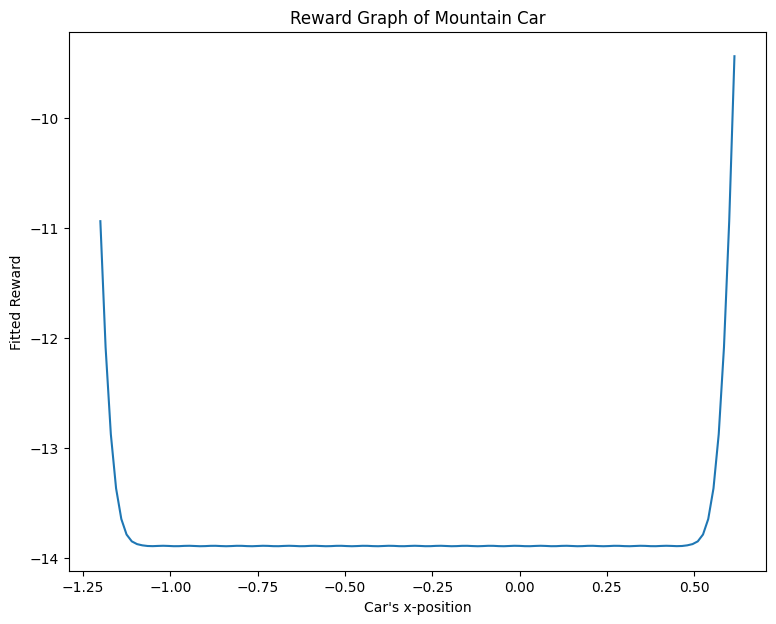

In [15]:
plot_fitted_reward(alphas, basis, xmin, xmax, x_binsize, std=0.05, 
                   filename='../Results/Mountain Car/Reward Function [Obtained from Expert].png')